<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/LTNE_model_rel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from itertools import product
import math
import pathlib
import os
import tensorflow as tf
from typing import Dict, Tuple, List

In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.1 MB/s eta 0:00:00


In [3]:
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [4]:
def ode_system(n, y, config:dict) -> list:
    T_f = y[:, 0:1]
    T_s = y[:, 1:2]

    # Compute first derivatives (jacobian) - only j=0 for 1D problem
    T_f_n = dde.grad.jacobian(T_f, n)
    T_s_n = dde.grad.jacobian(T_s, n)

    # Compute second derivatives (hessian) - only j=0 for 1D problem
    T_f_nn = dde.grad.hessian(T_f, n)
    T_s_nn = dde.grad.hessian(T_s, n)

    # Dynamic parameter handling
    def get_param(name):
        val = config["physics"][name]
        if name in config["physics"]["varying_params"]:
            if callable(val):
                return val(n)
            elif isinstance(val, (list, np.ndarray)):
                return val
        return val

    eps = get_param('eps')
    k = get_param('k')
    delta = get_param('delta')
    beta = get_param('beta')
    Bi = get_param('Bi')

    # Equations
    eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

    eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

    return [eqn1, eqn2]

In [5]:
#validation
def relation_dict(x: np.ndarray) -> dict:
  RELATIONS = {
      "relation_2_a" : {
            "network": { "neurons":264, "layers":3},  # Same as before
            "training": {"activation":"tanh", "lr":0.001,
                         "lose_weights": [1, 1, 10, 10, 1, 1],
                         "epochs":10000, "display_every":1000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": [ lambda x: 50.0 * tf.cast(1 - x, x.dtype),
                        lambda x: 50.0 * tf.cast(1 + x, x.dtype),
                        lambda x: 50.0 * tf.cast(1 - x**2, x.dtype),
                        lambda x: 50.0 * tf.cast(1 + x**2, x.dtype)],
                "varying_params": ["Bi"]  # Specify which params vary
            },
            "geometry": {
                "domain": [0.0, 1.0],
                "num_domain": 500,
                "num_boundary": 20,
            }
      },
      "relation_2_b" : {
            "network": { "neurons":264, "layers":3},  # Same as before
            "training": {"activation":"tanh", "lr":0.001,
                         "lose_weights": [1, 1, 10, 10, 1, 1],
                         "epochs":10000, "display_every":1000 },
            "physics": {
                "eps": 0.6,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": [ lambda x: 50.0 * tf.cast(1 - x, x.dtype),
                        lambda x: 50.0 * tf.cast(1 + x, x.dtype),
                        lambda x: 50.0 * tf.cast(1 - x**2, x.dtype),
                        lambda x: 50.0 * tf.cast(1 + x**2, x.dtype)],
                "varying_params": ["Bi"]  # Specify which params vary
            },
            "geometry": {
                "domain": [0.0, 1.0],
                "num_domain": 500,
                "num_boundary": 20,
            }
      }
  }
  return RELATIONS

In [6]:
# Define geometry (1D domain from 0 to 1)
geom = dde.geometry.Interval(0, 1)

# Boundary conditions
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

# Dirichlet BC at x=1
bc_Tf_right = dde.icbc.boundary_conditions.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
bc_Ts_right = dde.icbc.boundary_conditions.DirichletBC(geom, lambda x: 0, boundary_right, component=1)

# Neumann BC at x=0
bc_Tf_left = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0, boundary_left, component=0)
bc_Ts_left = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0, boundary_left, component=1)

In [12]:
from deepxde.callbacks import EarlyStopping, PDEPointResampler

In [7]:
class PINNTrainer:
  def __init__(self, config: Dict):
    self.config = config #hyperparameters, geometry, etc

  def build_model(self, data: dde.data) -> dde.Model:
    """ Generic model builder """
    nn = dde.nn.FNN(
        [1] + [self.config["network"]["neurons"]] * self.config["network"]["layers"] + [2],
        self.config["training"]["activation"],
        "Glorot uniform",
     )

    return dde.Model(data, nn)

  def train(self, model: dde.Model) -> dde.Model:
    #callbacks
    callbacks = [
       EarlyStopping(
            min_delta=1e-5,
            patience=6000,
            monitor="loss_train",
            start_from_epoch=1000
          ),
        # PDEPointResampler(
        #     period=100,
        #     pde_points=True,
        #     bc_points=True
        #   )
      ]

    """ Generic model trainer """
    model.compile("adam", lr = self.config["training"]["lr"] , loss_weights = self.config["training"]["lose_weights"], decay=("cosine", 2000,0.9 ))
    losshistory, train_state = model.train(iterations=self.config["training"]["epochs"], display_every = self.config["training"]["display_every"], callbacks = callbacks)


    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()
    return model, losshistory, train_state

In [9]:
def run_relation(relation_name: str, n: np.ndarray) -> list:
        """Handles any relation from the config without deepcopy issues"""
        config = relation_dict(n)[relation_name]
        results_predict = {}
        results_train = {}
        # Prepare parameter combinations for other relations
        varying_params = config["physics"]["varying_params"]
        param_values = [
            config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
            for p in varying_params
        ]

        for combo in product(*param_values):
            param_str = "_".join(f"{p}={v}" for p,v in zip(varying_params, combo))
            print(f"\nTraining {relation_name} with {param_str}") #help to track which combo is being trained

            #we make a new config for every combo
            current_physics = config["physics"].copy()
            for p, v in zip(varying_params, combo):
                current_physics[p] = v

            current_config = {
                "network": config["network"],
                "training": config["training"],
                "physics": current_physics
            }

            # Training setup
            ode_wrapped = lambda x, y: ode_system(x, y, current_config)
            data = dde.data.PDE(
                geom,
                ode_wrapped,
                [bc_Tf_right, bc_Ts_right, bc_Tf_left, bc_Ts_left],
                num_domain=300,
                num_boundary=50,
                num_test = 150,
                train_distribution="LHS"
            )

            # Build and train model
            model = PINNTrainer(current_config).build_model(data)
            Model, losshistory, train_state = PINNTrainer(current_config).train(model)

            # Store results
            T_pred = model.predict(n)

            n_train = data.train_x
            y_train = model.predict(n_train)

            results_predict[param_str] = {
                "x": n.flatten(),
                "T_f": T_pred[:, 0:1],
                "T_s": T_pred[:, 1:2],
                "params": dict(zip(varying_params, combo))
            }

            results_train[param_str] = {
                "x": n_train.flatten(),
                "T_f": y_train[:, 0:1],
                "T_s": y_train[:, 1:2],
                "params": dict(zip(varying_params, combo))
            }

        return [results_predict, results_train]

In [10]:
from collections import defaultdict
def plot_grouped_by_Bi(results:list, title_prefix="PINN Prediction Grouped by Bi"):
    """
    For each unique Bi (from result key), plot all (Tf, Ts) curves for that Bi in one figure.
    """
    for result in results:
      # Step 1: Group results by Bi
      grouped = defaultdict(dict)
      for key, res in result.items():
          # Parse key like "Bi=<func>_delta=0.4"
          bi_key = [kv for kv in key.split('_') if kv.startswith("Bi=")][0]
          grouped[bi_key][key] = res

      # Step 2: Plot each Bi group in its own figure
      for bi_label, group in grouped.items():
          plt.figure(figsize=(10, 6))
          colors = plt.cm.tab10.colors

          for i, (label, res) in enumerate(group.items()):
              x = res["x"]
              T_f = res["T_f"].flatten()
              T_s = res["T_s"].flatten()
              color = colors[i % len(colors)]

              plt.plot(x, T_s, color=color, linestyle='-')
              plt.plot(x, T_f, color=color, linestyle='--')

          plt.xlabel("x")
          plt.ylabel("Temperature")
          plt.title(f"{title_prefix}: {bi_label}")
          plt.legend(fontsize="small")
          plt.grid(True)
          plt.tight_layout()
          plt.show()



Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7cff81cfc220>
Compiling model...
Building feed-forward neural network...
'build' took 0.102100 s

'compile' took 1.350952 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.08e+02, 8.81e+01, 5.16e-03, 1.17e-01, 5.12e-04, 1.20e-02]    [1.06e+02, 8.60e+01, 5.16e-03, 1.17e-01, 5.12e-04, 1.20e-02]    []  
1000      [1.26e-01, 1.02e-01, 2.62e-03, 2.61e-04, 1.39e-02, 3.33e-02]    [1.23e-01, 7.69e-02, 2.62e-03, 2.61e-04, 1.39e-02, 3.33e-02]    []  
2000      [2.64e-02, 9.50e-03, 4.62e-04, 6.45e-05, 4.36e-03, 7.47e-03]    [2.50e-02, 7.54e-03, 4.62e-04, 6.45e-05, 4.36e-03, 7.47e-03]    []  
3000      [1.15e+00, 1.09e+00, 9.69e-04, 5.27e-04, 5.67e-03, 1.64e-03]    [9.76e-01, 9.21e-01, 9.69e-04, 5.27e-04, 5.67e-03, 1.64e-03]    []  
4000      [4.91e-02, 2.51e-02, 8.23e-04, 1.27e-04, 7.73e

/tmp/ipython-input-10-1104843971.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


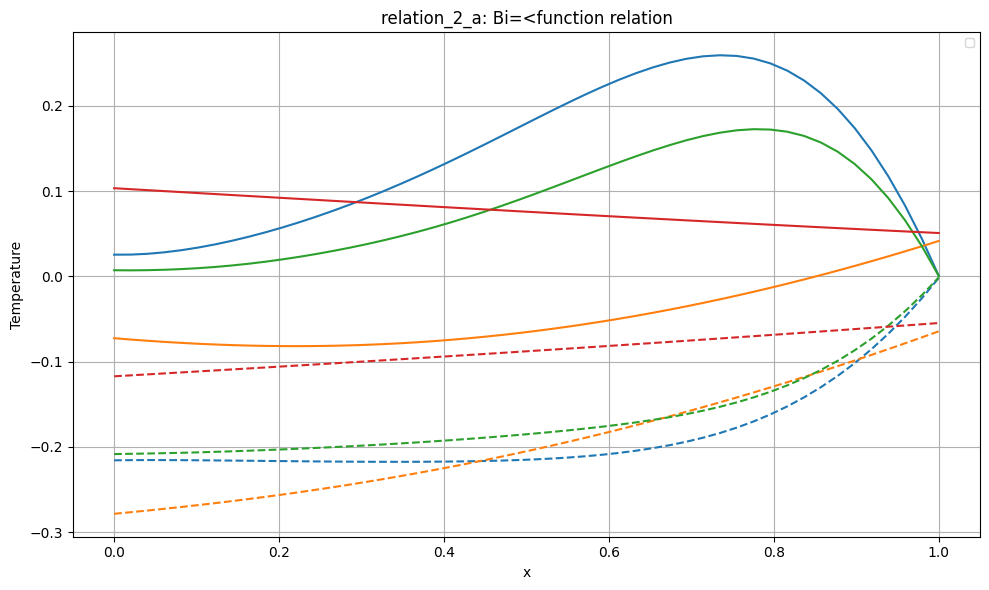

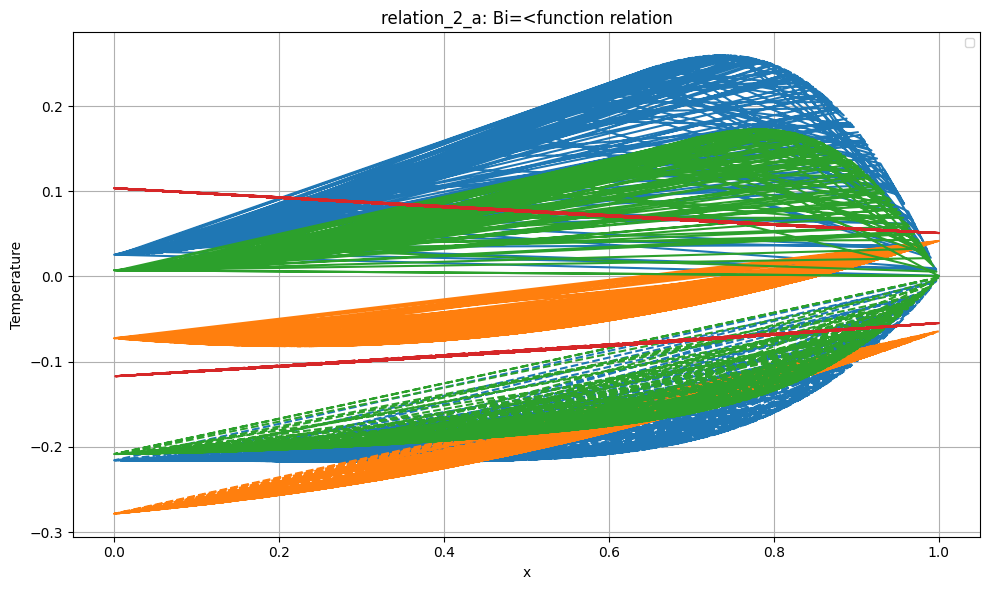


Training relation_2_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7cff18288720>
Compiling model...
Building feed-forward neural network...
'build' took 0.065684 s

'compile' took 1.074723 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.08e+02, 8.81e+01, 5.16e-03, 1.17e-01, 5.12e-04, 1.20e-02]    [1.06e+02, 8.61e+01, 5.16e-03, 1.17e-01, 5.12e-04, 1.20e-02]    []  
1000      [3.98e-01, 5.09e+00, 3.36e-01, 1.74e-01, 5.05e-03, 2.13e-01]    [3.76e-01, 2.78e+00, 3.36e-01, 1.74e-01, 5.05e-03, 2.13e-01]    []  
2000      [2.26e-02, 1.55e-01, 1.00e-03, 2.62e-05, 9.23e-03, 2.94e-02]    [2.29e-02, 9.38e-02, 1.00e-03, 2.62e-05, 9.23e-03, 2.94e-02]    []  
3000      [1.26e-03, 4.35e-02, 9.36e-05, 7.63e-06, 3.60e-03, 6.25e-03]    [1.18e-03, 3.92e-02, 9.36e-05, 7.63e-06, 3.60e-03, 6.25e-03]    []  
4000      [4.92e-01, 3.51e-01, 1.50e-02, 9.25e-03, 2.35e

/tmp/ipython-input-10-1104843971.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


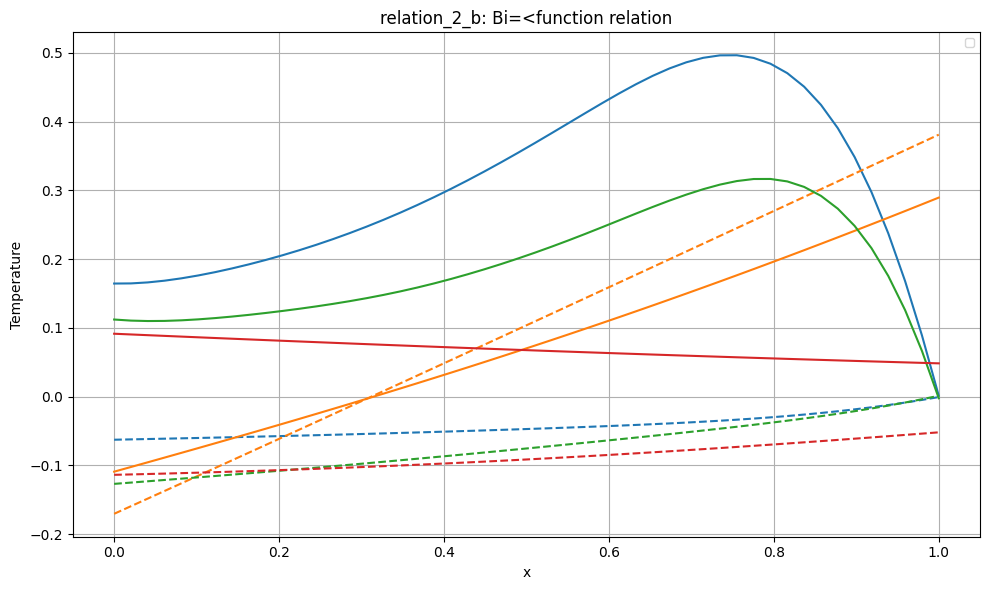

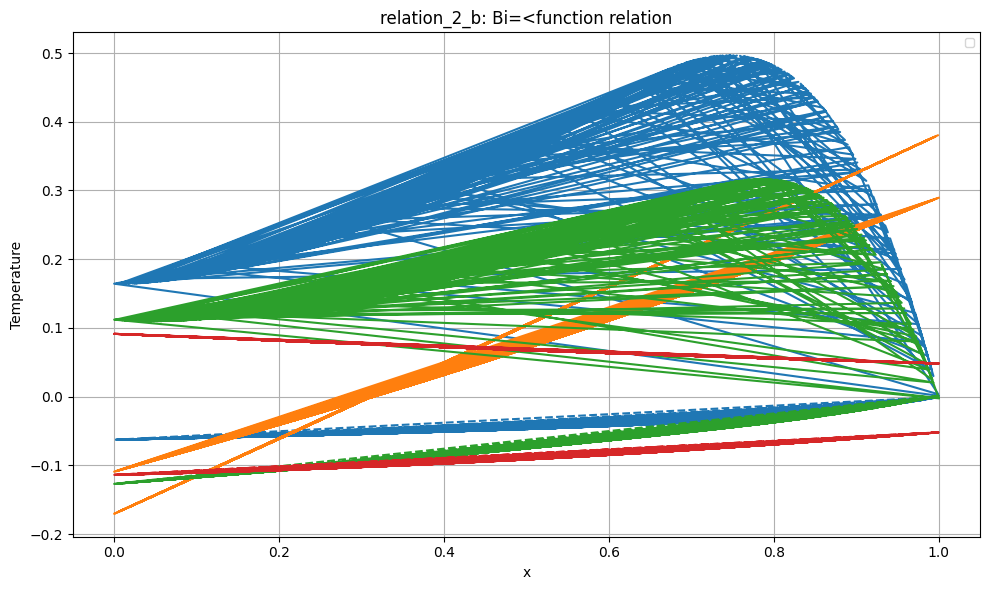

In [13]:
n = np.linspace(0, 1, 50).reshape(-1, 1)
all_results = {}

for relation in ["relation_2_a", "relation_2_b"]:
    all_results[relation] = run_relation(relation, n)
    plot_grouped_by_Bi(all_results[relation], title_prefix=relation)